In [307]:
import os
print(os.listdir("../input"))
%env JOBLIB_TEMP_FOLDER=/tmp # prevent memory issues
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from fastai.structured import *
from fastai.column_data import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
le = LabelEncoder()
from sklearn.model_selection import StratifiedKFold,GridSearchCV
fk = StratifiedKFold(n_splits=10)
from sklearn.metrics import accuracy_score, f1_score

['23OCT_23NOV_10.193.123.18_final.csv.xlsx', '27_Sep_23_Oct_10.193.123.18_final.csv.xlsx', '6th_Sep _27_Sep_10.193.123.18_final.csv.xlsx']
env: JOBLIB_TEMP_FOLDER=/tmp # prevent memory issues


In [308]:
df1 = pd.read_excel('../input/23OCT_23NOV_10.193.123.18_final.csv.xlsx')
df2 = pd.read_excel('../input/27_Sep_23_Oct_10.193.123.18_final.csv.xlsx')
df3 = pd.read_excel('../input/6th_Sep _27_Sep_10.193.123.18_final.csv.xlsx')

In [309]:
df1.shape,df2.shape,df3.shape

((6559, 71), (3664, 71), (4609, 71))

In [310]:
df = pd.concat([df1,df2,df3],axis=0)
df.shape

(14832, 71)

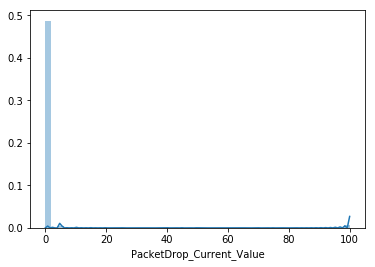

In [311]:
sns.distplot(df['PacketDrop_Current_Value'])

In [312]:
df.PacketDrop_Current_Value.describe()

count    14832.000000
mean         1.432039
std         11.493648
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: PacketDrop_Current_Value, dtype: float64

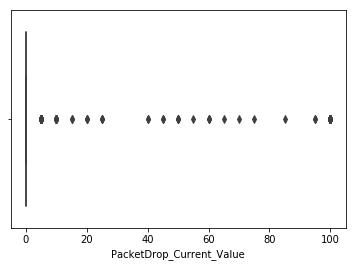

In [313]:
sns.boxplot(df.PacketDrop_Current_Value)

In [314]:
df.PacketDrop_Severity.value_counts()

up          14603
down          191
critical       21
warning        17
Name: PacketDrop_Severity, dtype: int64

In [315]:
df.PacketDrop_Severity = df.PacketDrop_Severity.map({'warning':4,'critical':3,'down':2,'up':1})

In [316]:
df.PacketDrop_Severity.value_counts()

1    14603
2      191
3       21
4       17
Name: PacketDrop_Severity, dtype: int64

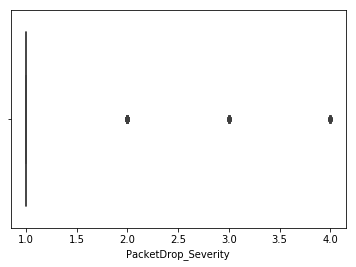

In [317]:
sns.boxplot(df.PacketDrop_Severity)

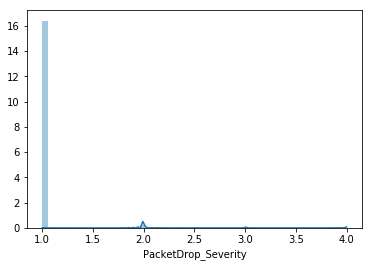

In [318]:
sns.distplot(df.PacketDrop_Severity)

In [319]:
# Columns that have null value
print(df.columns[df.isnull().sum()>0])
df = df.dropna(0)

Index(['UplinkJitter_Current_Value', 'UplinkJitter_Min_Current_Value',
       'UplinkJitter_Max_Current_Value', 'UplinkRSSI_Current_Value',
       'UplinkRSSI_Min_Current_Value', 'UplinkRSSI_Max_Current_Value',
       'Uptime_Current_Value', 'Uptime_Min_Current_Value',
       'Uptime_Max_Current_Value'],
      dtype='object')


In [320]:
df.Time = pd.to_datetime(df.Time)

df.Time = df.Time.dt.time

In [321]:
cat_vars = ['CRCErrors_Severity','DownlinkJitter_Severity','DownlinkRSSI_Severity','DownlinkRSSICritical.Threshold','DownlinkUtilization_Severity','Frequency_Severity',
            'Latency_Severity','SessionUptime_Severity','SSBeacon_Severity','SSProvisoningState_Current_Value','SSProvisoningState_Severity',
            'SSProvisoningState_Min_Current_Value','SSProvisoningState_Max_Current_Value','UplinkJitter_Severity','UplinkRSSI_Severity',
            'UplinkUtilization_Severity','Uptime_Severity']

In [322]:
#finding the class count of categorical variables
res = pd.DataFrame()
for i in cat_vars:
    res = pd.concat([res,pd.DataFrame(df[i].value_counts())],1)

res

,CRCErrors_Severity,DownlinkJitter_Severity,DownlinkRSSI_Severity,DownlinkRSSICritical.Threshold,DownlinkUtilization_Severity,Frequency_Severity,Latency_Severity,SessionUptime_Severity,SSBeacon_Severity,SSProvisoningState_Current_Value,SSProvisoningState_Severity,SSProvisoningState_Min_Current_Value,SSProvisoningState_Max_Current_Value,UplinkJitter_Severity,UplinkRSSI_Severity,UplinkUtilization_Severity,Uptime_Severity
Crititcal.Threshold,NaN,NaN,NaN,14782.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
critical,NaN,82.0,NaN,NaN,NaN,NaN,2534.0,NaN,176.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN
jitter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1104.0,NaN,1104.0,1104.0,NaN,NaN,NaN,NaN
normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13678.0,NaN,13678.0,13678.0,NaN,NaN,NaN,NaN
ok,14782.0,8056.0,14772.0,NaN,14782.0,14782.0,NaN,14782.0,14592.0,NaN,14782.0,NaN,NaN,14557.0,14641.0,14782.0,14782.0
up,NaN,NaN,NaN,NaN,NaN,NaN,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
warning,NaN,6644.0,10.0,NaN,NaN,NaN,12058.0,NaN,14.0,NaN,NaN,NaN,NaN,213.0,141.0,NaN,NaN


In [323]:
# dropping columns that have only single class
df = df.drop(['CRCErrors_Severity','DownlinkUtilization_Severity','Frequency_Severity','SessionUptime_Severity','SSProvisoningState_Severity',
              'UplinkUtilization_Severity','Uptime_Severity'],1)

In [324]:
cat_vars = ['DownlinkJitter_Severity','DownlinkRSSI_Severity','DownlinkRSSICritical.Threshold','Latency_Severity','SSBeacon_Severity','SSProvisoningState_Current_Value',
            'SSProvisoningState_Min_Current_Value','SSProvisoningState_Max_Current_Value','UplinkJitter_Severity','UplinkRSSI_Severity']

In [325]:
def ohe(train,features):
    """
    The functions takes the df1 with the list of arguments to be one hot encoded and returns a df1
    train is the df1 and features is a list
    """
    for v in features:
        df1 = train[v].values
        train = train.drop([v],axis=1)
        oh = OneHotEncoder(sparse=False)
        df1 = df1.reshape(len(df1),1)
        df1 = oh.fit_transform(df1)
        df1 = df1[:,1:]
        train.reset_index(inplace=True, drop=True)
        train = pd.concat([train,pd.DataFrame(df1).add_prefix(v)],axis=1,sort=False)
    return train

In [326]:
# one hot encoding the data
df = ohe(df,cat_vars)

In [327]:
dec = pd.DataFrame(df.describe())
dec = pd.DataFrame(dec.iloc[2])
dec.std = dec['std'].astype('float32')

In [328]:
# list of columns with std as 0
dec[dec.std==0].index

Index(['DownlinkJitter_Warning.Threshold', 'DownlinkJitter_Critical.Threshold',
       'DownlinkRSSI_Warning.Threshold', 'Frequency_Current_Value',
       'Frequency_Min_Current_Value', 'Frequency_Max_Current_Value',
       'Latency_Warning.Threshold', 'Latency_Critical.Threshold',
       'PacketDrop_Warning.Threshold', 'PacketDrop_Critical.Threshold',
       'SSBeacon_Warning.Threshold', 'SSBeacon_Critical.Threshold',
       'UplinkJitter_Warning.Threshold', 'UplinkJitter_Critical.Threshold',
       'UplinkRSSI_Warning.Threshold', 'UplinkRSSI_Critical.Threshold'],
      dtype='object')

In [329]:
df = df.drop(['Time','DownlinkJitter_Warning.Threshold', 'DownlinkJitter_Critical.Threshold',
       'DownlinkRSSI_Warning.Threshold', 'Frequency_Current_Value',
       'Frequency_Min_Current_Value', 'Frequency_Max_Current_Value',
       'Latency_Warning.Threshold', 'Latency_Critical.Threshold',
       'PacketDrop_Warning.Threshold', 'PacketDrop_Critical.Threshold',
       'SSBeacon_Warning.Threshold', 'SSBeacon_Critical.Threshold',
       'UplinkJitter_Warning.Threshold', 'UplinkJitter_Critical.Threshold',
       'UplinkRSSI_Warning.Threshold', 'UplinkRSSI_Critical.Threshold'],1)

In [330]:
df.head()

,CRCErrors_Current_Value,CRCErrors_Min_Current_Value,CRCErrors_Max_Current_Value,DownlinkJitter_Current_Value,DownlinkJitter_Min_Current_Value,DownlinkJitter_Max_Current_Value,DownlinkRSSI_Current_Value,DownlinkRSSI_Min_Current_Value,DownlinkRSSI_Max_Current_Value,DownlinkUtilization_Current_Value,DownlinkUtilization_Min_Current_Value,DownlinkUtilization_Max_Current_Value,Latency_Current_Value,Latency_Min_Current_Value,Latency_Max_Current_Value,PacketDrop_Current_Value,PacketDrop_Severity,PacketDrop_Min_Current_Value,PacketDrop_Max_Current_Value,SessionUptime_Current_Value,SessionUptime_Min_Current_Value,SessionUptime_Max_Current_Value,SSBeacon_Current_Value,SSBeacon_Min_Current_Value,SSBeacon_Max_Current_Value,UplinkJitter_Current_Value,UplinkJitter_Min_Current_Value,UplinkJitter_Max_Current_Value,UplinkRSSI_Current_Value,UplinkRSSI_Min_Current_Value,UplinkRSSI_Max_Current_Value,UplinkUtilization_Current_Value,UplinkUtilization_Min_Current_Value,UplinkUtilization_Max_Current_Value,Uptime_Current_Value,Uptime_Min_Current_Value,Uptime_Max_Current_Value,DownlinkJitter_Severity0,DownlinkJitter_Severity1,DownlinkRSSI_Severity0,Latency_Severity0,Latency_Severity1,SSBeacon_Severity0,SSBeacon_Severity1,SSProvisoningState_Current_Value0,SSProvisoningState_Min_Current_Value0,SSProvisoningState_Max_Current_Value0,UplinkJitter_Severity0,UplinkJitter_Severity1,UplinkRSSI_Severity0
0,4,4,4,5.0,5,5,-57.0,-57,-57,0.02,0.02,0.02,39.722,39.722,39.722,0,1,0,0,12047.0,12047,12047,99.0,99,99,2.0,2.0,2.0,-60.0,-60.0,-60.0,0.01,0.01,0.01,1329708.0,1329708.0,1329708.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,4,4,4,5.0,5,5,-56.0,-56,-56,0.00,0.00,0.00,39.155,39.155,39.155,0,1,0,0,12342.0,12342,12342,99.0,99,99,3.0,3.0,3.0,-59.0,-59.0,-59.0,0.00,0.00,0.00,1330003.0,1330003.0,1330003.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,4,4,4,4.0,4,4,-55.0,-55,-55,0.00,0.00,0.00,38.901,38.901,38.901,0,1,0,0,12932.0,12932,12932,99.0,99,99,2.0,2.0,2.0,-59.0,-59.0,-59.0,0.00,0.00,0.00,1330593.0,1330593.0,1330593.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
3,4,4,4,3.0,3,3,-55.0,-55,-55,0.00,0.00,0.00,40.305,40.305,40.305,0,1,0,0,13227.0,13227,13227,99.0,99,99,2.0,2.0,2.0,-59.0,-59.0,-59.0,0.00,0.00,0.00,1330888.0,1330888.0,1330888.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,4,4,4,5.0,5,5,-55.0,-55,-55,0.00,0.00,0.00,38.816,38.816,38.816,0,1,0,0,13522.0,13522,13522,99.0,99,99,4.0,4.0,4.0,-59.0,-59.0,-59.0,0.00,0.00,0.00,1331183.0,1331183.0,1331183.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


In [331]:
# feature importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [332]:
df = df.astype('float32')

In [333]:
X, y, nas, mapper = proc_df(df, 'PacketDrop_Current_Value', do_scale=True)

In [334]:
#y = df['PacketDrop_Current_Value'].values
#X = df.drop(['PacketDrop_Current_Value'],1)

In [335]:
xgbmdl = XGBClassifier()
xgbmdl.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

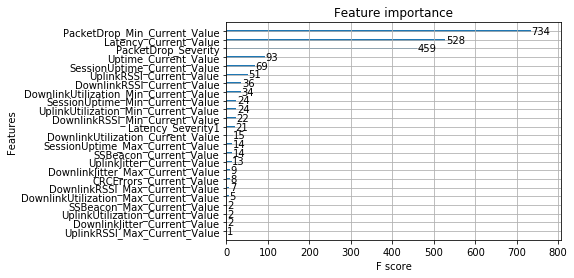

In [336]:
# Feature importance plot
plot_importance(xgbmdl)
pyplot.show()

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [338]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape #,X_val.shape, y_val.shape

((10347, 49), (4435, 49), (10347,), (4435,))

In [339]:
"""
# creating the model
xgbmdl_f = XGBClassifier()

param_grid = {'learning_rate':[0.01],
              'max_depth':[1],
              'gamma':[0.01],
              'reg_lambda':[0.1],
             'reg_alpha':[0.1]}

grid = GridSearchCV(xgbmdl_f ,param_grid , verbose=0, n_jobs=3)
"""

"\n# creating the model\nxgbmdl_f = XGBClassifier()\n\nparam_grid = {'learning_rate':[0.01],\n              'max_depth':[1],\n              'gamma':[0.01],\n              'reg_lambda':[0.1],\n             'reg_alpha':[0.1]}\n\ngrid = GridSearchCV(xgbmdl_f ,param_grid , verbose=0, n_jobs=3)\n"

In [340]:
#grid.best_params_

In [ ]:
xg = XGBClassifier(learning_rate=0.01,max_depth=1,gamma=0.01,reg_alpha=0.1,reg_lambda=0.1)
xg.fit(X_train,y_train)
y_pred = xg.predict(X_test)
#xgbmdl_f.fit(X_train,y_train)

In [ ]:
f1_score(y_test,y_pred,average='macro')

In [ ]:
accuracy_score(y_test,y_pred)